# <a id='toc1_'></a>[Implied vs. Historical Volatility in VaR Estimation](#toc0_)
A Quantitative Study

**Disclosure**: I utitlized **ChatGPT V4.0** for English writting refinments and **Github's Copilot** for function and class documentations defined in `src` directory. 

**Table of contents**<a id='toc0_'></a>    
- [Implied vs. Historical Volatility in VaR Estimation](#toc1_)    
  - [Theory](#toc1_1_)    
    - [Value at Risk (VaR)](#toc1_1_1_)    
    - [Parametric and Non-Parametric VaR](#toc1_1_2_)    
    - [Implied Volatility](#toc1_1_3_)    
  - [Implementation](#toc1_2_)    
  - [Discussion](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Theory](#toc0_)

### <a id='toc1_1_1_'></a>[Value at Risk (VaR)](#toc0_)
Value at Risk (VaR) is a statistical technique used to measure and quantify the level of financial risk within a firm or investment portfolio over a specific time frame. This metric is most commonly used by investment and commercial banks to determine the extent and occurrence ratio of potential losses in their institutional portfolios. The VaR model can be mathematically expressed as follows:

$VaR_{\alpha} = -\inf \{ x \in \mathbb{R} : P(L \ge x) \le 1 - \alpha \}$

where $L$ is the loss variable and $\alpha$ is the significance level.

### <a id='toc1_1_2_'></a>[Parametric and Non-Parametric VaR](#toc0_)
1. **Parametric VaR**: Also known as the variance-covariance method, this approach assumes that returns are normally distributed. In this method, VaR is calculated by estimating the mean (expected return) and standard deviation (volatility) of the portfolio.
$ VaR_{\alpha} = \mu - Z_{\alpha} \cdot \sigma $

where $\mu$ is the mean return, $Z_\alpha$​ is the z-value from the standard normal distribution corresponding to the desired confidence level $\alpha$, and $\sigma$ is the standard deviation of returns.

2. Non-Parametric VaR: This method does not make any assumptions about the return distribution. Historical Simulation and Monte Carlo Simulation are two popular non-parametric methods. In the Historical Simulation approach, historical data is used to calculate the VaR, and for Monte Carlo Simulation, many random portfolio outcomes are generated to estimate VaR.

### <a id='toc1_1_3_'></a>[Implied Volatility](#toc0_)

Implied volatility (IV) is a metric that captures the market's expectation of future volatility. In the Black-Scholes model, implied volatility is the volatility expectation that is implied by the market price of the option. The IV can be computed using the following equation derived from the Black-Scholes model:

$C = S_0 e^{-qt} N(d1) - X e^{-rt} N(d2)$

Where

$d1 = \frac{ln(\frac{S_0}{X}) + (r - q + \frac{\sigma^2}{2})t}{\sigma \sqrt{t}}$
and $d2 = d1 - \sigma \sqrt{t}$ 

and $C$ is the market price of the option, $S_0$ is the current price of the underlying, $X$ is the strike price, $t$ is the time to maturity, $r$ is the risk-free rate, $q$ is the dividend yield, $\sigma$ is the volatility, and $N(.)$ is the cumulative distribution function of the standard normal distribution. Here, the implied volatility is the value of 
$\sigma$ that solves the equation.

In [22]:
# silent warnings
import warnings
warnings.filterwarnings("ignore")

## <a id='toc1_2_'></a>[Implementation](#toc0_)

In our analysis, we'll utilize the `Option` namedtuple from `src.data`, as previously introduced in Project 1, to define a new option.

In [24]:
from src.data import Option
option = Option(
    tag="SHASTA_CALL",
    stock_symbol="شستا",
    option_symbol="ضستا6006",
    strike=1065,
    maturity_date="1402-06-08",
    call=True
)

Next, we'll retrieve the data for both the option and its corresponding underlying stock. Like in Project 1, we'll enrich this dataset by adding a rolling annualized standard deviation and Time-to-Maturity (TtM) for each trading day. We'll also append the risk-free rate (rf) to each row.

In [25]:
from src.data import fetch_data
df = fetch_data(option=option)

from src.data import add_std, add_T, add_rf
df = add_std(df, rolling_window=90)
df.rename(columns={"std": "rolling_std"}, inplace=True)
df = add_T(option=option, data=df)
df = add_rf(data=df)

We'll further enhance the dataframe by appending `stock_returns`. Alongside this, we'll incorporate a 90-day rolling window for the historical Value at Risk (VaR), computed with a 95 percent confidence interval.

In [26]:
df['stock_returns'] = df['S0'].pct_change()
df['historical_VaR'] = df['stock_returns'].rolling(90).quantile(0.05)

Following that, we'll incorporate an `implied_vol` column into the dataframe. This is achieved by leveraging the `Volatility` class defined in `src.option`, specifically its `implied_volatility` function, applying it to every row. Subsequently, we present the final entries of our updated dataframe.

In [29]:
from src.options import Volatility

import pandas as pd
import numpy as np
def calc_implied_vol(row):
    if any(pd.isnull(row)):
        return np.nan
    return Volatility.implied_volatility(row['S0'], option.strike, row['T'], row['rf'], row['actual_option'], row['rolling_std'])

df['implied_vol'] = df.apply(calc_implied_vol, axis=1)
df.tail(8)

,date,S0,actual_option,rolling_std,T,rf,stock_returns,historical_VaR,implied_vol
278,2023-06-27,1304.0,306.0,0.343149,0.175342,0.2622,-0.018811,-0.033737,0.552312
279,2023-06-28,1284.0,305.0,0.344124,0.172603,0.2622,-0.015337,-0.033737,0.693116
280,2023-07-01,1274.0,274.0,0.343341,0.164384,0.2622,-0.007788,-0.033737,0.539575
281,2023-07-02,1286.0,295.0,0.343274,0.161644,0.2622,0.009419,-0.033737,0.641743
282,2023-07-03,1306.0,295.0,0.341978,0.158904,0.2622,0.015552,-0.033737,0.481984
283,2023-07-04,1316.0,320.0,0.341945,0.156164,0.2622,0.007657,-0.033737,0.656965
284,2023-07-05,1315.0,338.0,0.341130,0.153425,0.2622,-0.000760,-0.033737,0.820877
285,2023-07-08,1307.0,313.0,0.341207,0.145205,0.2622,-0.006084,-0.033737,0.708251


Following this, we calculate the estimated Value at Risk using the `rolling_std` and `implied_vol` columns. Notably, for a fair comparison with the previously computed daily historical VaR, we must convert these new VaRs to daily values as well. This is accomplished by multiplying them by `np.sqrt(1/252)`, accounting for the typical number of trading days in a year.

<Axes: >

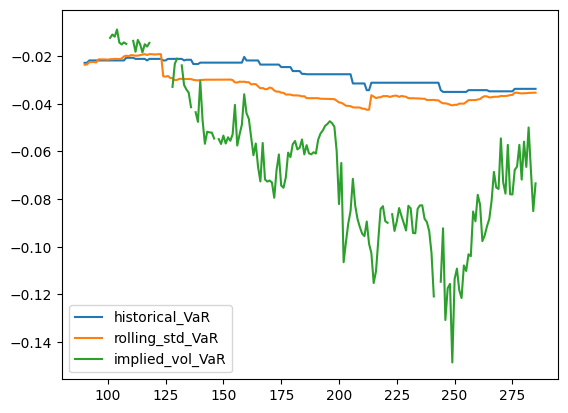

In [30]:
from scipy.stats import norm
Z_95 = norm.ppf(1-0.05)
df['rolling_std_VaR'] = - Z_95 * df['rolling_std'] * np.sqrt(1/252)
df['implied_vol_VaR'] = - Z_95 * df['implied_vol'] * np.sqrt(1/252)
df[['historical_VaR', 'rolling_std_VaR', 'implied_vol_VaR']].plot()

The aforementioned process is replicated for the set of five options that were defined in Project 1, ensuring a consistent methodology across all our analyses.

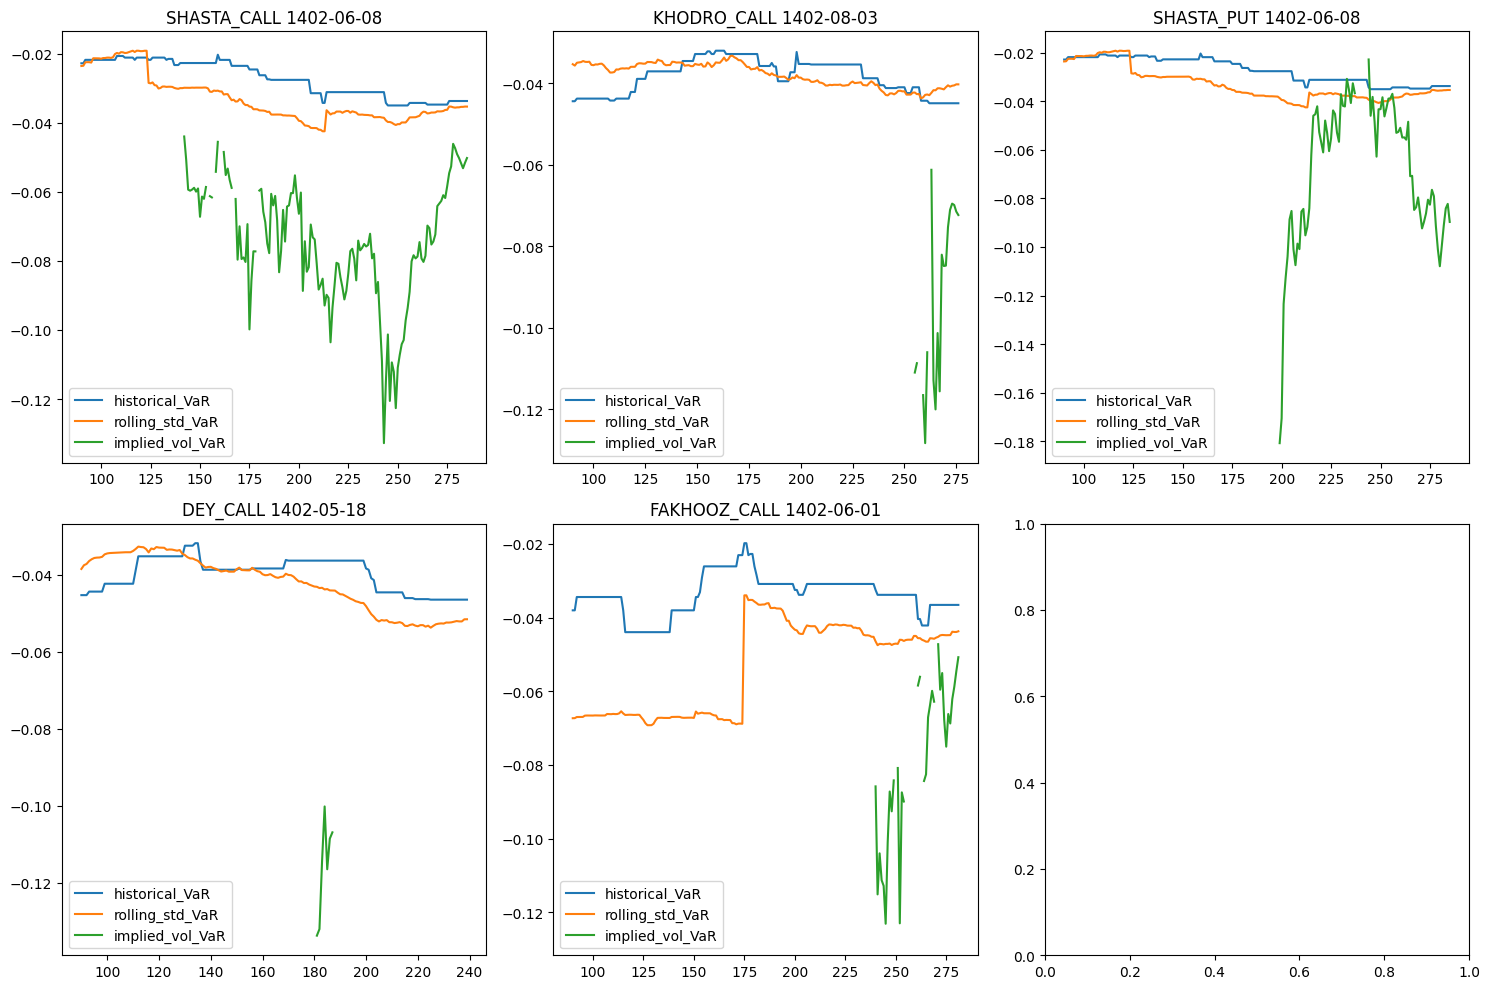

In [31]:
option1 = Option(
    tag="SHASTA_CALL",
    stock_symbol="شستا",
    option_symbol="ضستا6009",
    strike=1365,
    maturity_date="1402-06-08",
    call=True,
)
option2 = Option(
    tag="KHODRO_CALL",
    stock_symbol="خودرو",
    option_symbol="ضخود8024",
    strike=4000,
    maturity_date="1402-08-03",
    call=True,
)
option3 = Option(
    tag="SHASTA_PUT",
    stock_symbol="شستا",
    option_symbol="طستا6010",
    strike=1465,
    maturity_date="1402-06-08",
    call=False,
)
option4 = Option(
    tag="DEY_CALL",
    stock_symbol="دی",
    option_symbol="ضدی500",
    strike=800,
    maturity_date="1402-05-18",
    call=True,
)
option5 = Option(
    tag="FAKHOOZ_CALL",
    stock_symbol="فخوز",
    option_symbol="ضخوز6002",
    strike=4000,
    maturity_date="1402-06-01",
    call=True,
)
options = [option1, option2, option3, option4, option5]
option_tags = [f'{option.tag} {option.maturity_date}' for option in options]

results: list[pd.DataFrame] = []

for option in options:
    df = fetch_data(option=option)
    df = add_std(df, rolling_window=90)
    df.rename(columns={"std": "rolling_std"}, inplace=True)
    df = add_T(option=option, data=df)
    df = add_rf(data=df)

    df['stock_returns'] = df['S0'].pct_change()
    df['historical_VaR'] = df['stock_returns'].rolling(90).quantile(0.05)

    df['implied_vol'] = df.apply(calc_implied_vol, axis=1)

    df['rolling_std_VaR'] = - Z_95 * df['rolling_std'] * np.sqrt(1/252)
    df['implied_vol_VaR'] = - Z_95 * df['implied_vol'] * np.sqrt(1/252)
    results.append(df[['historical_VaR', 'rolling_std_VaR', 'implied_vol_VaR']])

import matplotlib.pyplot as plt
_, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, df in enumerate(results):
    ax = axes[i//3, i%3]
    df.plot(ax=axes[i//3, i%3])
    ax.set_title(option_tags[i])

plt.tight_layout()
plt.show()

## <a id='toc1_3_'></a>[Discussion](#toc0_)

Our analysis reveals that the Value at Risk (VaR) calculated using the rolling standard deviation (rolling_std) provides a closer approximation to the actual historical VaR than does the VaR derived from implied volatility. **Although the ultimate benchmark for comparison should be the respective forecasting power of these methods, it's evident from the plots that the VaR calculated via implied volatility significantly deviates from the historical values.** Consequently, it inherently possesses weaker predictive capacity.

The reason why rolling_std yields a closer approximation to historical VaR lies in the inherent nature of VaR calculation. If returns follow a normal or quasi-normal distribution, the rolling_std based approach aligns with the definition of VaR, as both methods fundamentally capture the standard deviation of historical returns. As a result, these methods inherently produce similar results.

On the other hand, implied volatility is derived from the market prices of options, and therefore, it is a forward-looking measure. It captures the market's expectation of future volatility, taking into account the demand and supply dynamics of the options market. This might not always accurately reflect the underlying asset's historical price volatility, especially in periods of market stress or uncertainty. Therefore, it is not necessarily surprising that VaR computed using implied volatility deviates from the historical VaR.

Furthermore, the implied volatility method assumes a lognormal distribution of returns, which may not be an accurate representation, particularly in the presence of 'fat tails' observed in financial return distributions. This discrepancy can result in significant differences when calculating VaR.

In summary, while implied volatility is a powerful tool for options pricing and provides valuable insight into market sentiment, its use as a singular measure for VaR computation and forecasting might not always yield accurate results. This underscores the importance of using a combination of methods to forecast VaR, to capture both historical trends and market expectations.
